In [1]:
%matplotlib inline
import itertools
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import pickle
from scipy.optimize import curve_fit

In [2]:
# Define a function to deserialize the data
def deserialize(name, folder_name):
    with open(os.path.join(folder_name, name + ".pkl"), 'rb') as f:
        data = pickle.load(f, encoding='latin1', fix_imports=True)
    return data

In [3]:
train_size = 1024
test_size = 529
train_path = 'samples/train_data_f1_plain_' + str(train_size)
test_path = 'samples/test_data_f1_plain_' + str(test_size) + '/'

# Training and Testing samples
x_test, y_test = deserialize("x_test", test_path), deserialize("y_test", test_path)

In [4]:
#definition of a cost function
def mse(pred, truth):
    res = []
    for p, t in zip(pred, truth):
        res.append((p[0]-t[0])**2)
    return np.array(res)

In [5]:
archs = [(6, 1), (7, 1), (12, 1), (17, 1), (22, 1), (27, 1), (32, 1),
    (6, 2), (8, 2), (10, 2), (12, 2), (14, 2), (16, 2),
    (6, 3), (8, 3), (10, 3)]

full_err = np.array([])
full_out = np.array([])
full_dist = np.array([])
full_xtest = np.array([])
X = x_test.detach().numpy().reshape(1, len(x_test))[0]

for width, depth in archs:
    for sampling_method in ['REG', 'UNI', 'SOB']:
        for state in ['plain', 'hole']:
            path = "serialized_" + state + "/serialized_data_" + sampling_method
            for test_num in range(1, 18):
                # Deserialize the data using pickle
                folder_name = path + f"_{width}_{depth}_{test_num}"
                list_names = ["mean_dist", "num_out", "output_test"]
                list_data = []
                for name in list_names:
                    list_data.append(deserialize(name, folder_name))
                mean_dist = list_data[0]
                num_out = list_data[1]
                output_test = list_data[2].detach().numpy()
                gen_err = mse(output_test, y_test)

                stack = np.column_stack((num_out, mean_dist, X, gen_err))

                if state == 'plain':
                    # create a boolean mask based on your conditions
                    mask = np.logical_or((-6 <= stack[:, 2]) & (stack[:, 2] <= -3), (3 <= stack[:, 2]) & (stack[:, 2] <= 6))
                else:
                    mask = np.logical_or((-4 <= stack[:, 2]) & (stack[:, 2] <= -1), (1 <= stack[:, 2]) & (stack[:, 2] <= 4))

                full_err = np.concatenate((full_err, stack[mask][:, 3]))
                full_out = np.concatenate((full_out, stack[mask][:, 0]))
                full_dist = np.concatenate((full_dist, stack[mask][:, 1]))
                full_xtest = np.concatenate((full_xtest, stack[mask][:, 2]))

Slope (a): 0.04076705165418754
Intercept (b): 0.3327971191052155


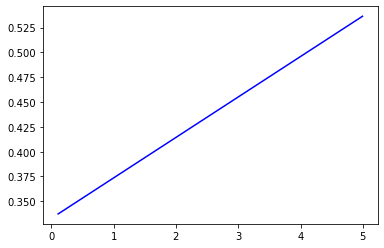

In [6]:
# calculate polynomial
z_dist = np.polyfit(full_dist, full_err, 1)
f_dist = np.poly1d(z_dist)
a = z_dist[0] # slope
b = z_dist[1] # intercept

# print coefficients
print("Slope (a):", a)
print("Intercept (b):", b)

# calculate new x's and y's
x_dist = np.linspace(min(full_dist), max(full_dist), 100)
y_dist = f_dist(x_dist)

plt.plot(x_dist, y_dist, color='blue')
#plt.plot(full_dist, full_err, '.', color='blue')
plt.show()

Slope (a_out): -0.0015300715238903435
Intercept (b_out): 0.4031967580723287
Slope (a): 0.04076705165418754
Intercept (b): 0.3327971191052155


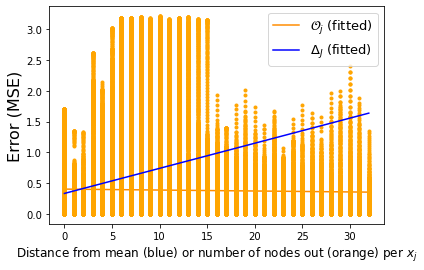

In [7]:
# calculate polynomial
z_out = np.polyfit(full_out, full_err, 1)
a_out = z_out[0] # slope
b_out = z_out[1] # intercept

# print coefficients
print("Slope (a_out):", a_out)
print("Intercept (b_out):", b_out)

# calculate new x's and y's
x_out = np.linspace(min(full_out), max(full_out), 100)
y_out = a_out*x_out + b_out

plt.plot(x_out, y_out, label=r"$\mathcal{O}_j$ (fitted)", color='darkorange')
plt.plot(full_out, full_err, '.', color='orange')

z_dist = np.polyfit(full_dist, full_err, 1)
a_dist = z_dist[0] # slope
b_dist = z_dist[1] # intercept

# print coefficients
print("Slope (a):", a_dist)
print("Intercept (b):", b_dist)

# calculate new x's and y's
x_dist = np.linspace(min(full_out), max(full_out), 100)
y_dist = a_dist*x_dist + b_dist

plt.plot(x_dist, y_dist, label=r"$\Delta_J$ (fitted)", color='blue')

plt.xlabel(r"Distance from mean (blue) or number of nodes out (orange) per $x_j$", fontsize=12)
plt.ylabel("Error (MSE)", fontsize=16)
plt.legend(fontsize=13)
plt.savefig("images/SineNetsUnseen.png", dpi=100)